In [ ]:
import keras
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

def cross_validation_split(trainY, k):
    index = [[] for _ in range(10)]
    for idx in range(len(trainY)):
        index[trainY[idx]].append(idx)

    min_length = min(len(arr) for arr in index if len(arr) > 0)
    if min_length < k:
        raise ValueError("k quá lớn so với số mẫu của ít nhất một lớp")

    indexValidation = []
    indexTrain = []

    for i in range(len(index)):
        if len(index[i]) > 0:
            selected = np.random.choice(index[i], size=min_length // k, replace=False)
            indexValidation.extend(selected)
            indexTrain.extend([idx for idx in index[i] if idx not in selected])

    return np.random.permutation(indexValidation), np.random.permutation(indexTrain)

def showim(x_train, y_train):
    plt.figure(figsize=(10, 10))
    for i in range(x_train.shape[0]):
        plt.subplot(3, 3, i + 1)  # Tạo lưới 3x3
        plt.imshow(x_train[i], cmap='gray')  # Hiển thị hình ảnh
        plt.title(f'Nhãn: {y_train[i]}')  # Thêm tiêu đề cho mỗi hình ảnh
        plt.axis('off')  # Tắt trục

    plt.tight_layout()  # Đảm bảo các hình ảnh không chồng chéo
    plt.show()


def transform_images(x_train, rotation_range=(-20, 20), width_shift_range=0.1, height_shift_range=0.1, zoom_range=(0.8, 1.2), shear_range=0.2):
    # Khởi tạo mảng để lưu hình ảnh đã biến đổi
    x_train_transformed = np.zeros_like(x_train)

    for i in range(x_train.shape[0]):
        # Chọn một hình ảnh từ x_train
        image = x_train[i]
        pil_image = Image.fromarray(image)

        # 1. Xoay hình ảnh
        angle = np.random.uniform(rotation_range[0], rotation_range[1])
        pil_image = pil_image.rotate(angle, expand=True)

        # 2. Dịch chuyển ngang
        width_shift = np.random.uniform(-width_shift_range, width_shift_range) * pil_image.size[0]
        height_shift = np.random.uniform(-height_shift_range, height_shift_range) * pil_image.size[1]
        pil_image = pil_image.transform(pil_image.size, Image.AFFINE, (1, 0, width_shift, 0, 1, height_shift))

        # 3. Phóng to hoặc thu nhỏ
        zoom_factor = np.random.uniform(zoom_range[0], zoom_range[1])
        new_size = (int(pil_image.size[0] * zoom_factor), int(pil_image.size[1] * zoom_factor))
        pil_image = pil_image.resize((x_train.shape[1], x_train.shape[2]), Image.LANCZOS)

        # 4. Kéo dãn
        shear_angle = np.random.uniform(-shear_range, shear_range)
        shear_matrix = (1, shear_angle, 0, 0, 1, 0)
        pil_image = pil_image.transform(pil_image.size, Image.AFFINE, shear_matrix)

        # Resize back to original shape
        pil_image = pil_image.resize((x_train.shape[1], x_train.shape[2]),  Image.LANCZOS)

        # 5. Chuyển đổi hình ảnh đã biến đổi về numpy array và lưu vào mảng đã khởi tạo
        x_train_transformed[i] = np.array(pil_image)

    return x_train_transformed

# Assuming cross_validation_split is defined and y_train is provided
validation_indices, train_indices = cross_validation_split(y_train, 5)


# Lấy dữ liệu huấn luyện và kiểm tra dựa trên chỉ số
x_rotate_train = transform_images(x_train, zoom_range=(0.9, 1.1), shear_range=0.1, rotation_range=(-10, 10))
x_train_cv = x_rotate_train[train_indices]
y_train_cv = y_train[train_indices]

x_validation_cv = x_rotate_train[validation_indices]
y_validation_cv = y_train[validation_indices]


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Kiểm tra kích thước dữ liệu
print(f'Kích thước dữ liệu huấn luyện: {x_train_cv.shape}, {y_train_cv.shape}')
print(f'Kích thước dữ liệu kiểm tra: {x_validation_cv.shape}, {y_validation_cv.shape}')

Kích thước dữ liệu huấn luyện: (49160, 28, 28), (49160,)
Kích thước dữ liệu kiểm tra: (10840, 28, 28), (10840,)


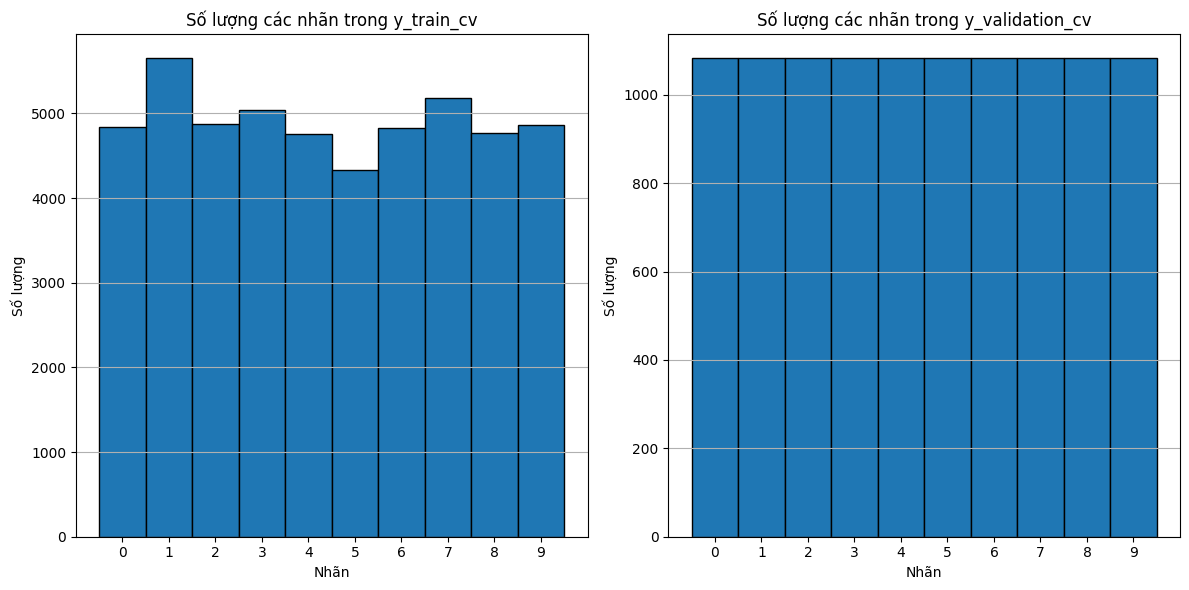

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(y_train_cv, bins=np.arange(11) - 0.5, edgecolor='black')
plt.xticks(range(10))
plt.title('Số lượng các nhãn trong y_train_cv')
plt.xlabel('Nhãn')
plt.ylabel('Số lượng')
plt.grid(axis='y')

plt.subplot(1, 2, 2)
plt.hist(y_validation_cv, bins=np.arange(11) - 0.5, edgecolor='black')
plt.xticks(range(10))
plt.title('Số lượng các nhãn trong y_validation_cv')
plt.xlabel('Nhãn')
plt.ylabel('Số lượng')
plt.grid(axis='y')

plt.tight_layout()
plt.show()

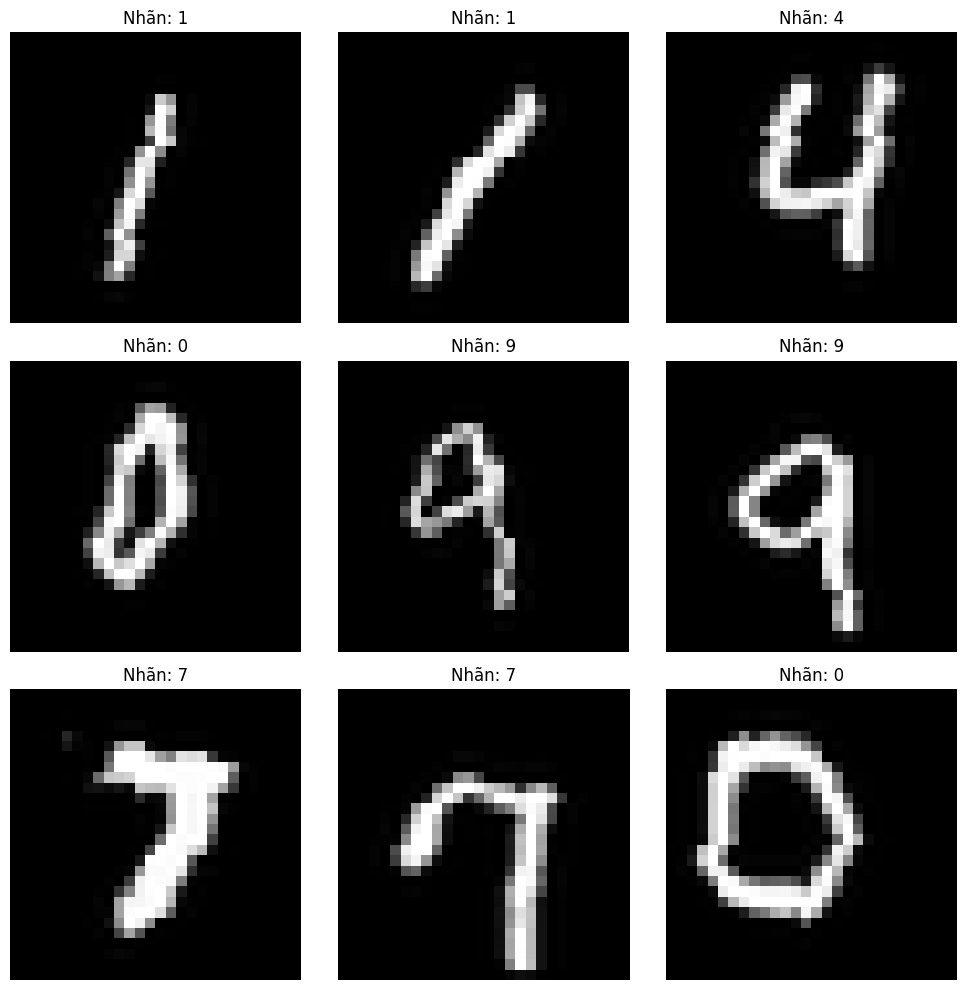

In [ ]:
showim(x_train_cv[0:9],y_train_cv[0:9])

In [ ]:

x_rotate_train = x_rotate_train.reshape(x_rotate_train.shape[0], 28, 28, 1)
x_rotate_test = transform_images(np.squeeze(x_test), zoom_range=(0.9, 1.1), shear_range=0.1, rotation_range=(-10, 10))
x_rotate_test = x_rotate_test.reshape(x_rotate_test.shape[0], 28, 28, 1)


y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)
x_rotate_train = x_rotate_train.astype('float32')
x_rotate_test = x_rotate_test.astype('float32')
x_rotate_train /= 255
x_rotate_test /= 255
print('x_rotate_train shape:', x_rotate_train.shape)
print(x_rotate_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')


x_rotate_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [ ]:
batch_size = 16
num_classes = 10
epochs = 20 #10


def evaluate_model(model, x_test, y_test, hist):
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    plt.plot(hist.history['accuracy'], label='Train Accuracy')
    plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

    plt.plot(hist.history['loss'], label='Train Loss')
    plt.plot(hist.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

def create_and_train_model(architecture, x_train, y_train, batch_size=16, epochs=20):
    validation_indices, train_indices = cross_validation_split(np.argmax(y_train, axis=1), 5)
    # Tạo mô hình
    model = Sequential()

    # Thêm các lớp dựa trên kiến trúc được cung cấp
    for layer in architecture:
        if layer['type'] == 'conv':
            model.add(Conv2D(layer['filters'], kernel_size=layer['kernel_size'], activation='relu', input_shape=(28, 28, 1) if 'input_shape' not in layer else None))
        elif layer['type'] == 'pool':
            model.add(MaxPooling2D(pool_size=layer['pool_size']))

    # Thêm lớp Flatten trước khi các lớp Dense
    model.add(Flatten())

    for layer in architecture:
        if layer['type'] == 'dense':
            model.add(Dense(layer['units'], activation='relu'))
            if 'dropout' in layer:
                model.add(Dropout(layer['dropout']))

    # Lớp đầu ra
    model.add(Dense(num_classes, activation='softmax'))

    # Biên dịch mô hình
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    # Huấn luyện mô hình
    hist = model.fit(x_train[train_indices], y_train[train_indices], batch_size=batch_size,epochs=epochs,
                     verbose=1, validation_data=(x_train[validation_indices], y_train[validation_indices]),callbacks=[early_stopping])
    evaluate_model(model, x_train[validation_indices], y_train[validation_indices], hist)

    return hist


def plot_accuracy_histories(histories):
    plt.figure(figsize=(10, 6))
    for name, history in histories.items():
        plt.plot(history.history['val_accuracy'], label=name)

    plt.title('Model Validation Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Accuracy')
    plt.legend()
    plt.show()

# Ví dụ về kiến trúc mô hình
architectures = [
    [{'type': 'conv', 'filters': 512, 'kernel_size': (5, 5)},
     {'type': 'pool', 'pool_size': (2, 2)},
     {'type': 'conv', 'filters': 1024, 'kernel_size': (5, 5)},
     {'type': 'pool', 'pool_size': (2, 2)},
     {'type': 'flatten'},
     {'type': 'dense', 'units': 128, 'dropout': 0.1},
    ]
]

# Huấn luyện và lưu kết quả
histories = {}
for i, arch in enumerate(architectures):
    name = f'Architecture {i + 1}'
    histories[name] = create_and_train_model(arch, x_rotate_train, y_train,batch_size,epochs)

# Vẽ biểu đồ
plot_accuracy_histories(histories)

In [ ]:
from tensorflow.keras import layers, models

In [ ]:
from tensorflow.keras import layers, models

modelReal = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1),padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(128, (5, 5), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(10, activation='softmax')
])

modelReal.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
epochs =5
batch_size = 16
recognize = modelReal.fit(x_rotate_train, y_train, batch_size=batch_size,epochs=epochs,
                     verbose=1, validation_data=(x_rotate_test, y_test),callbacks=[early_stopping])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


NameError: name 'x_rotate_test' is not defined

In [ ]:
layers = modelReal.layers
for layer in layers:
    print(layer.name)
print(modelReal.get_layer("conv2d_1"))
modelReal.summary()

conv2d
max_pooling2d
conv2d_1
max_pooling2d_1
flatten
dense
dropout
dense_1
<Conv2D name=conv2d_1, built=True>


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 10, 10, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,849,760 (7.06 MB)

 Trainable params: 616,586 (2.35 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,233,174 (4.70 MB)

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def grad_cam(model, img_array, last_conv_layer_name, pred_index=None, threshold=0.5):

    grad_model = tf.keras.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.outputs]
    )

    # Tính toán gradient
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        predictions = predictions[0]
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]


    # Tính gradient của lớp dự đoán với đầu ra của lớp convolution
    grads = tape.gradient(class_channel, conv_outputs)

    # Tính gradient trung bình không gian
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Nhân gradient với đầu ra của lớp convolution
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Chuẩn hóa bản đồ nhiệt
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = np.where(heatmap > threshold, heatmap, 0)
    return heatmap


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def display_gradcam(img, heatmap, alpha=0.6):

    if len(img.shape) == 2 or img.shape[-1] == 1:  # Nếu là ảnh trắng đen
        img = np.stack([img] * 3, axis=-1)  # Chuyển thành RGB

    # Chuẩn hóa heatmap để giá trị nằm trong khoảng [0, 1]
    heatmap = np.uint8(255 * heatmap)

    # Resize heatmap về kích thước của ảnh gốc
    heatmap = tf.keras.preprocessing.image.array_to_img(heatmap)
    heatmap = heatmap.resize((img.shape[1], img.shape[0]))
    heatmap = np.array(heatmap)

    # Chuyển heatmap thành dạng RGB với màu Jet
    heatmap = plt.cm.jet(heatmap / 255.0)[:, :, :3]  # Normalize về [0, 1]
    heatmap = np.uint8(255 * heatmap)

    # Chồng heatmap lên ảnh gốc
    superimposed_img = np.uint8(img * (1 - alpha) + heatmap * alpha)

    plt.figure(figsize=(10, 5))

    # Ảnh gốc
    plt.subplot(1, 2, 1)  # 1 hàng, 2 cột, vị trí 1
    plt.imshow(img.astype('uint8'))
    plt.title("Ảnh gốc")
    plt.axis('off')

    # Ảnh thêm heatmap
    plt.subplot(1, 2, 2)  # 1 hàng, 2 cột, vị trí 2
    plt.imshow(superimposed_img)
    plt.title("Ảnh với heatmap")
    plt.axis('off')

    plt.tight_layout()
    plt.show()



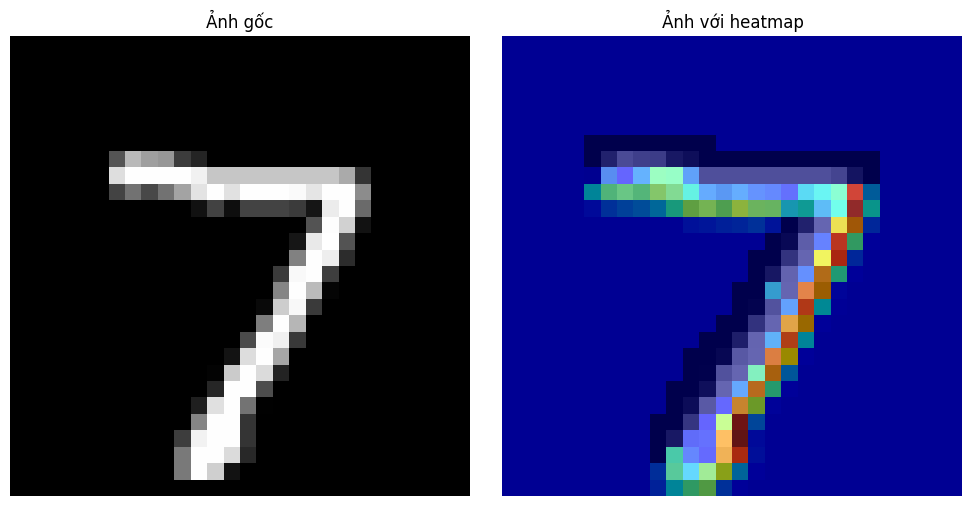

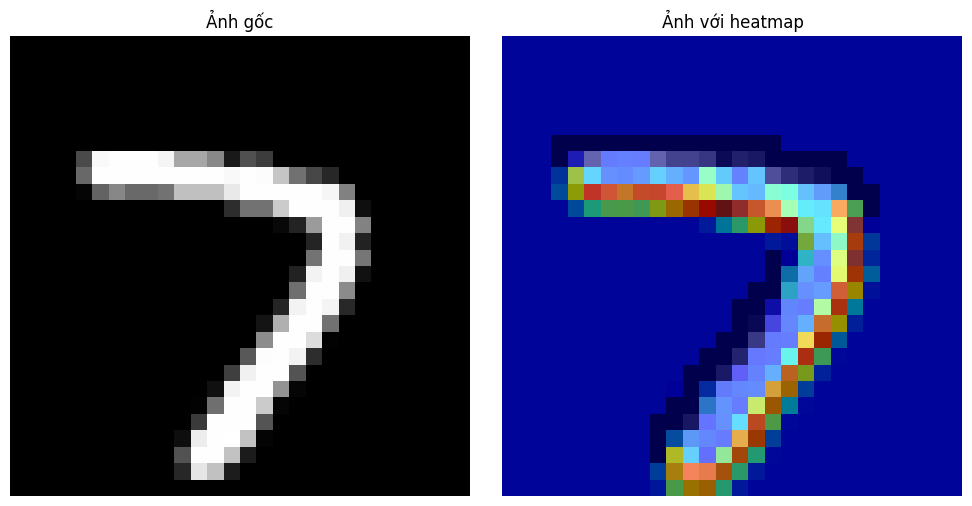

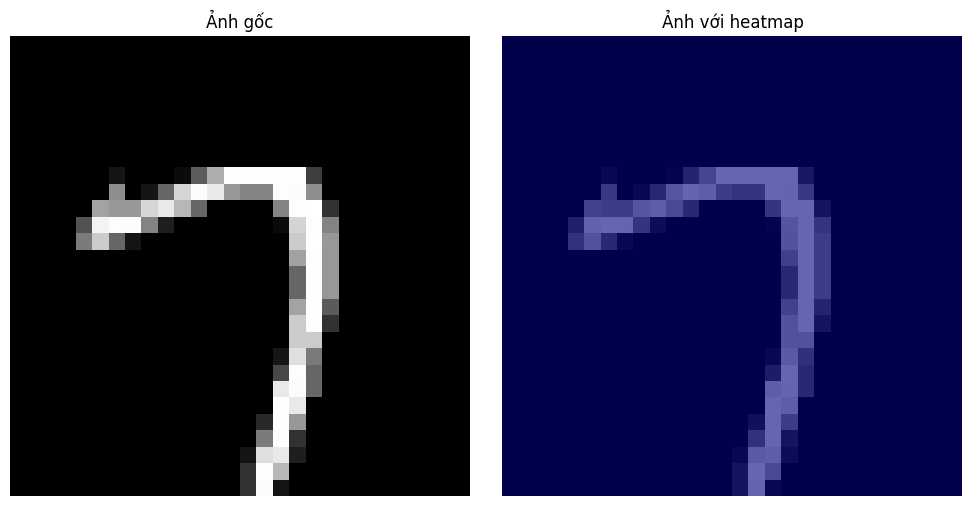

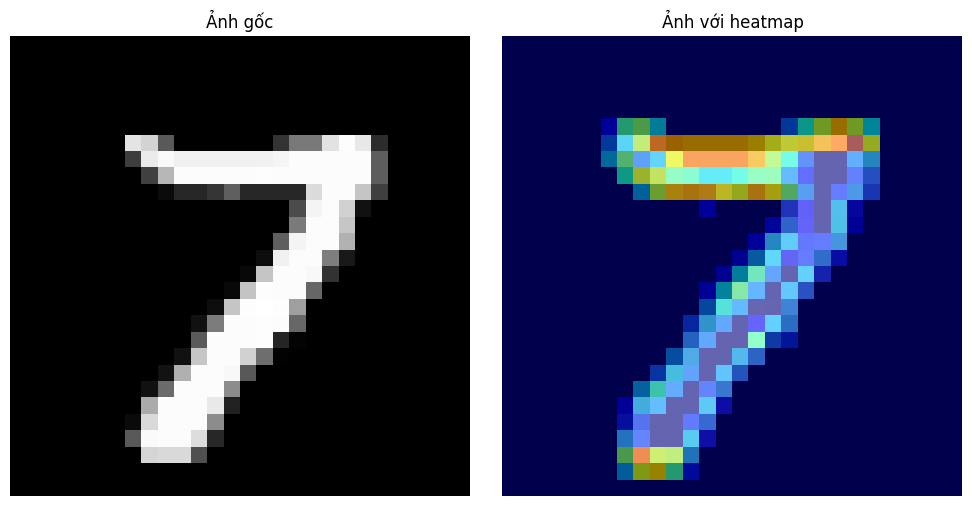

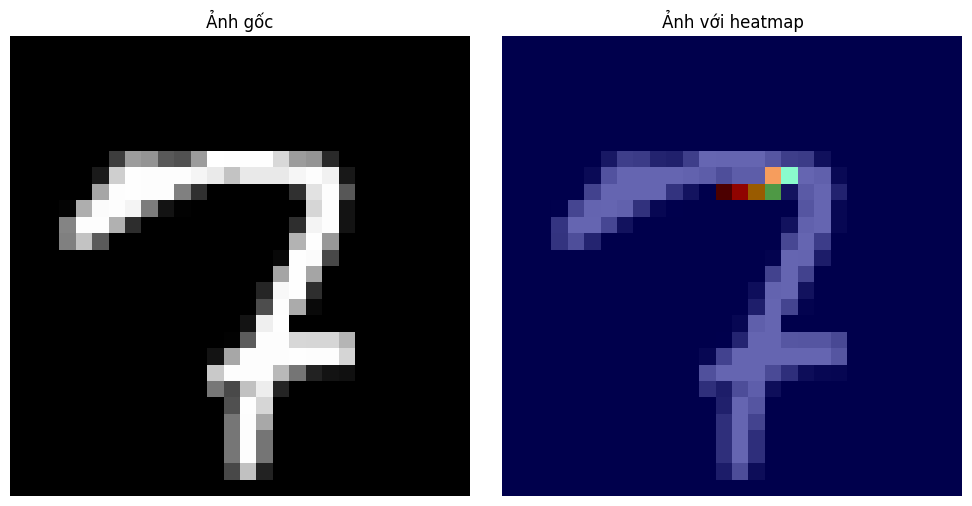

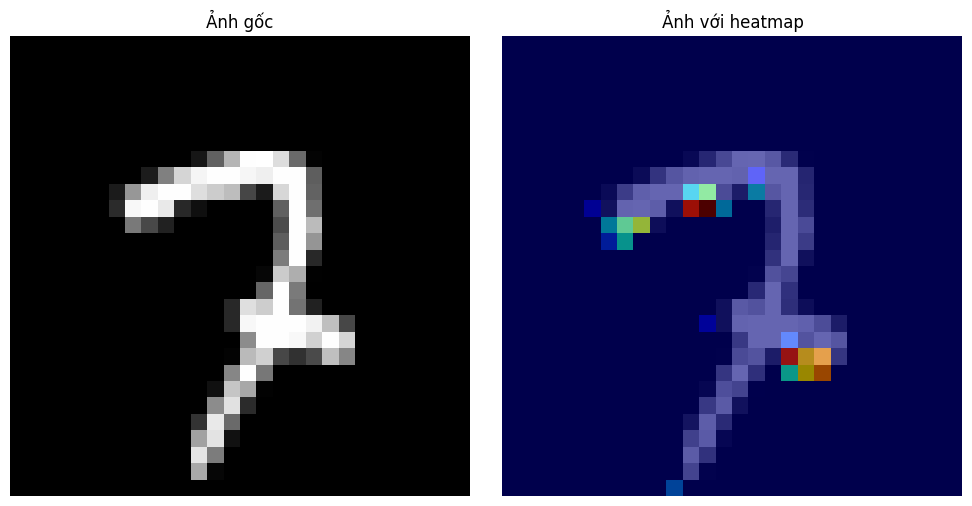

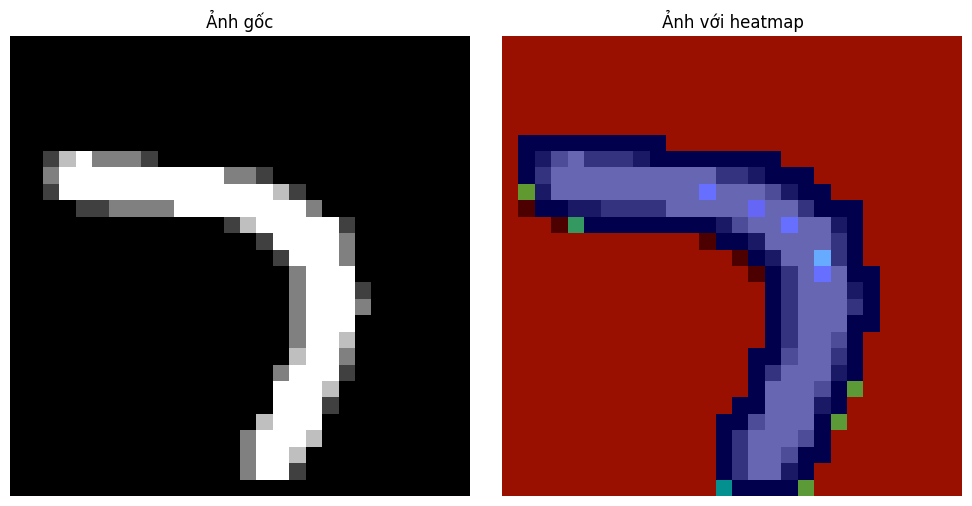

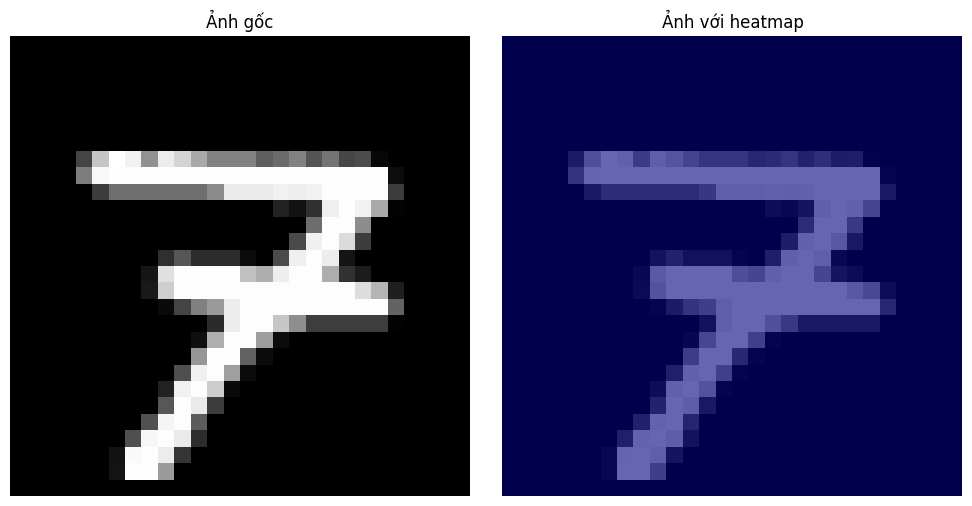

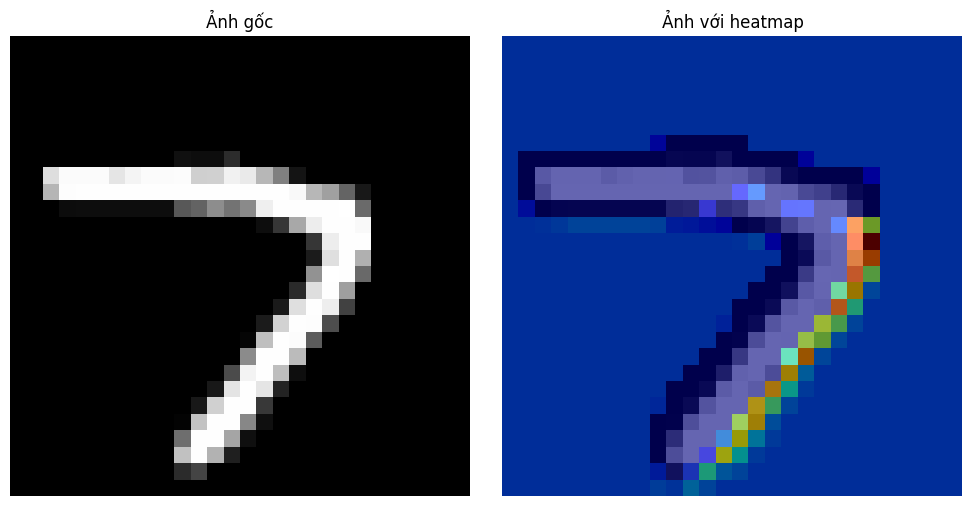

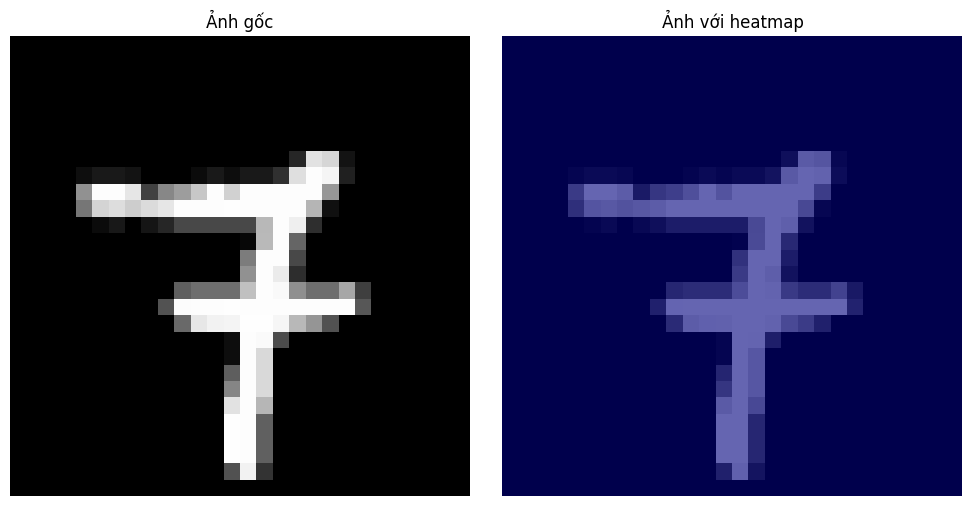

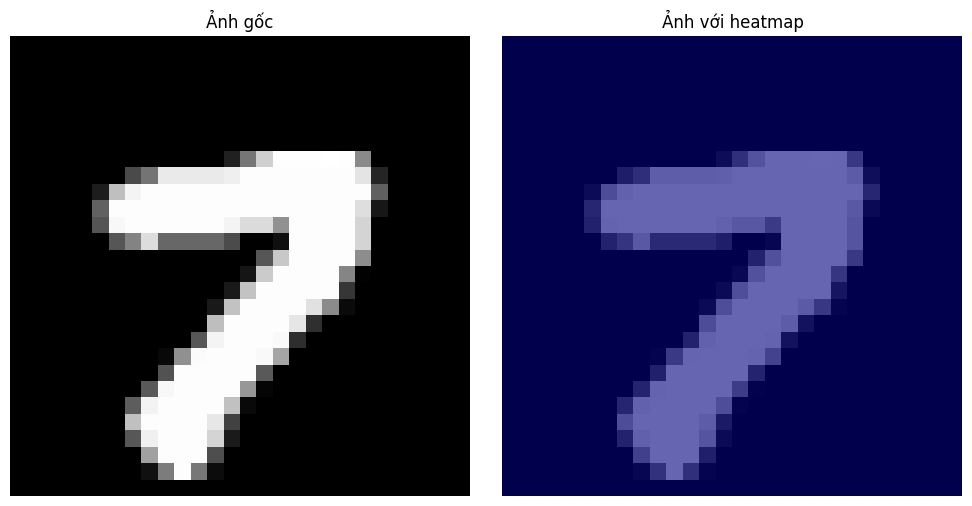

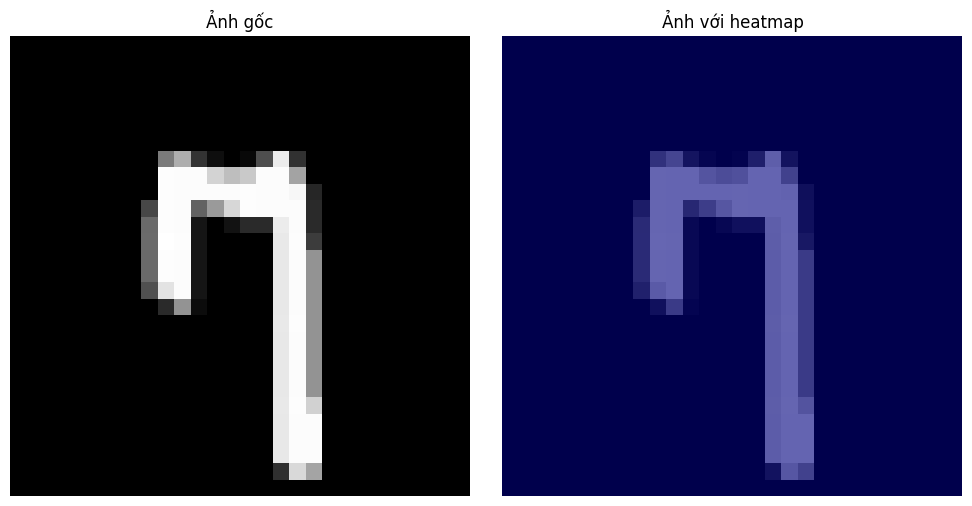

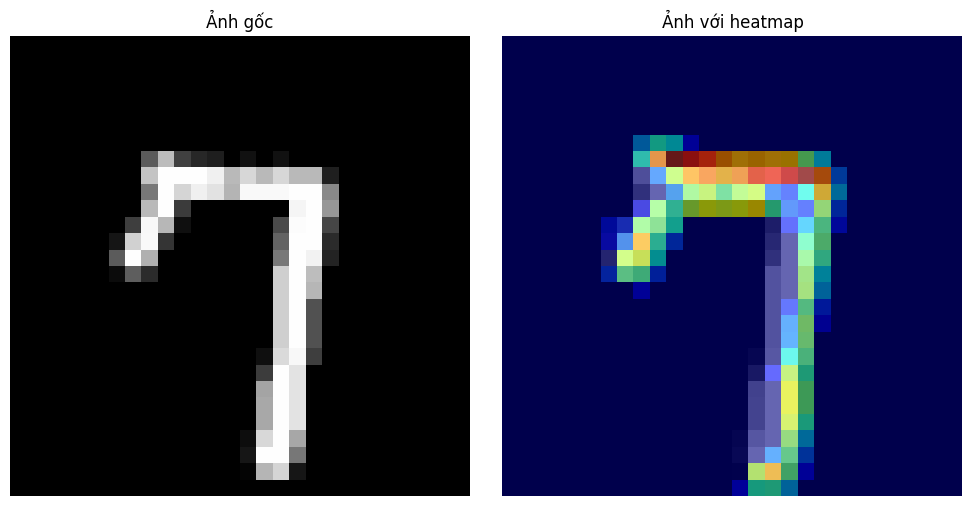

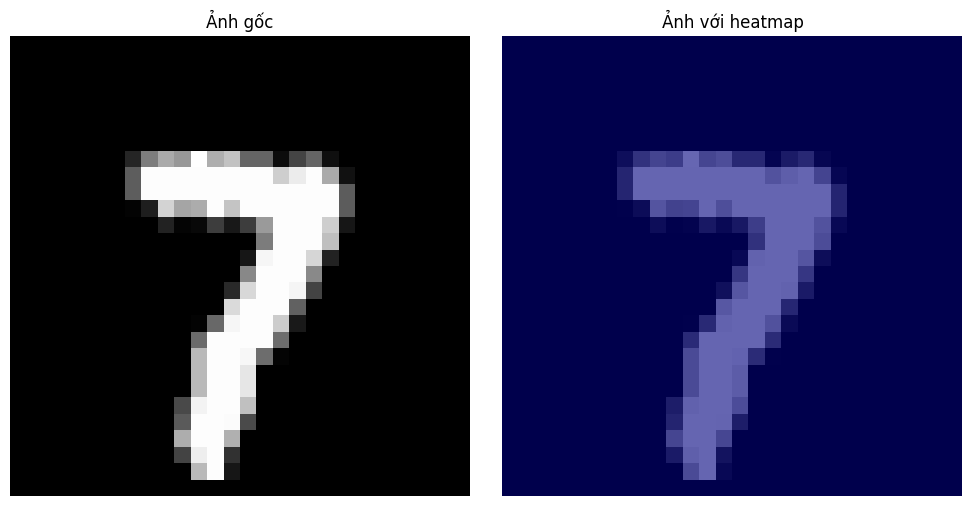

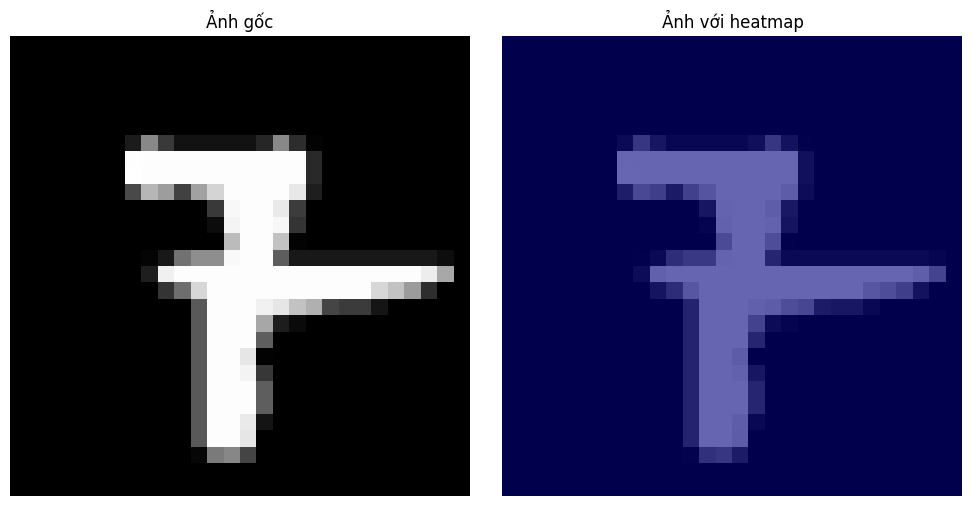

In [ ]:
last_conv_layer_name = "conv2d_1"
target_label = 7
y_test_labels = np.argmax(y_test, axis=1)
indices = np.where(y_test_labels == target_label)[0]
for i in indices:
    if i >100:
      break
    img = x_test[i]
    img_array = img.reshape(1, 28, 28, 1).astype("float32") /255.0

    heatmap = grad_cam(modelReal, img_array, last_conv_layer_name,threshold=0.1)
    heatmap = np.expand_dims(heatmap, axis=-1)
    # Hiển thị Grad-CAM
    display_gradcam(img, heatmap)

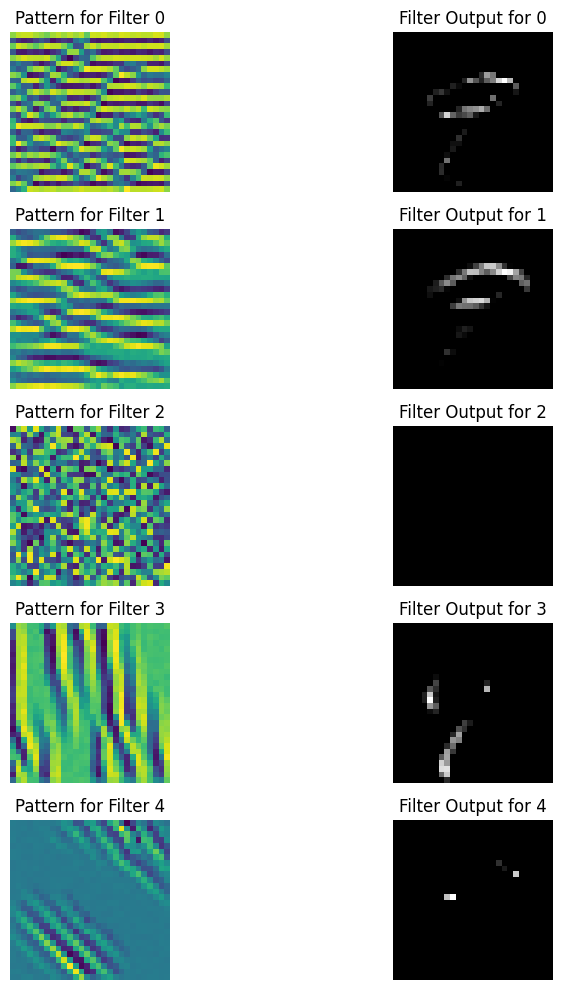

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

def generate_pattern(layer_name, filter_index, size=28, iterations=3000, step=0.05):

    input_img = tf.random.uniform((1, size, size, 1))

    submodel = tf.keras.Model(inputs=[modelReal.inputs], outputs=modelReal.get_layer(layer_name).output)

    for i in range(iterations):
        with tf.GradientTape() as tape:
            tape.watch(input_img)
            output = submodel(input_img)
            loss = tf.reduce_mean(output[:, :, :, filter_index])

        grads = tape.gradient(loss, input_img)
        grads = tf.math.l2_normalize(grads)

        input_img += step * grads

    return input_img[0].numpy()

def extract_filter_output(layer_name, filter_index, test_image):
    submodel = tf.keras.Model(inputs=[modelReal.inputs], outputs=modelReal.get_layer(layer_name).output)
    output = submodel(test_image)

    filter_output = output[0, :, :, filter_index]
    return filter_output.numpy()

layer_name = "conv2d"
num_filters = 32
size = 28

# feature_map = get_feature_map(input_image, modelReal, layer_name)

fig, axes = plt.subplots(4, 8, figsize=(12, 6))
for i in range(num_filters):
    pattern = generate_pattern(layer_name, i, size=size)
    ax = axes[i // 8, i % 8]
    ax.matshow(pattern[:, :, 0], cmap='viridis')
    ax.axis('off')

plt.tight_layout()
plt.show()